# 02.B: Nearest neighbors classifiers

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mylib as my

## Nearest Neighbor (NN)
Given and dataset $\boldsymbol{D} = [\boldsymbol{X}\ \ \boldsymbol{y}]$ and an unseen example $\boldsymbol{x}$, this classifier:
* calculates the distances between $\boldsymbol{x}$ and every example in $\boldsymbol{D}$. Using the Euclidean distance, we have:
    $$
      distance(\boldsymbol{x^{(a)}}, \boldsymbol{x^{(b)}}) = \Vert\boldsymbol{x^{(a)}} - \boldsymbol{x^{(b)}}\Vert_2 = \sqrt{\sum_{i = 1}^{m} (x_i^{(a)} - x_i^{(b)})^2}
    $$
* finds the example that is nearest to X and return its $y$ 

Here is a class implementing this classifier

In [2]:
class NearestNeighborClassifier:
    def __init__(self, dataset):
        self.ds = dataset
        
    def calc_distance(self, x, y):
        distance = 0.0
        for i in np.arange(len(x)):
            distance += (x[i] - y[i])**2
                
        return math.sqrt(distance)
    
    def predict(self, unseen):
        if unseen.ndim == 1:
            distances = np.full(self.ds.N, 0.0)
            for i, ex in enumerate(self.ds.inputs):
                distances[i] = self.calc_distance(unseen, ex)

            return self.ds.target[distances.argmin()]
        else:
            return np.array([self.predict(ex) for ex in unseen])

## An example
Let's quickly test this. Here is a sample dataset with three classes:

In [3]:
basis = np.array([[3, 14],[4, 4],[10, 9]])
a_ = np.concatenate((
        basis[0,0] + np.random.normal(loc=1, scale=2.5, size=(50, 1)), 
        basis[0, 1] + np.random.normal(loc=1, scale=2.6, size=(50, 1)), 
        np.full(50, 0).reshape(50,1)), axis= 1)

b_ = np.concatenate((
        basis[1,0] + np.random.normal(loc=.8, scale=2.5, size=(50, 1)), 
        basis[1, 1] + np.random.normal(loc=.8, scale=2.4, size=(50, 1)), 
        np.full(50, 1).reshape(50,1)), axis= 1)

c_ = np.concatenate((
        basis[2,0] + np.random.normal(loc=.5, scale=2.5, size=(50, 1)), 
        basis[2, 1] + np.random.normal(loc=.5, scale=2.6, size=(50, 1)), 
        np.full(50, 2).reshape(50,1)), axis= 1)

which looks like this:

Text(0.5, 1.0, 'Samle three classes data')

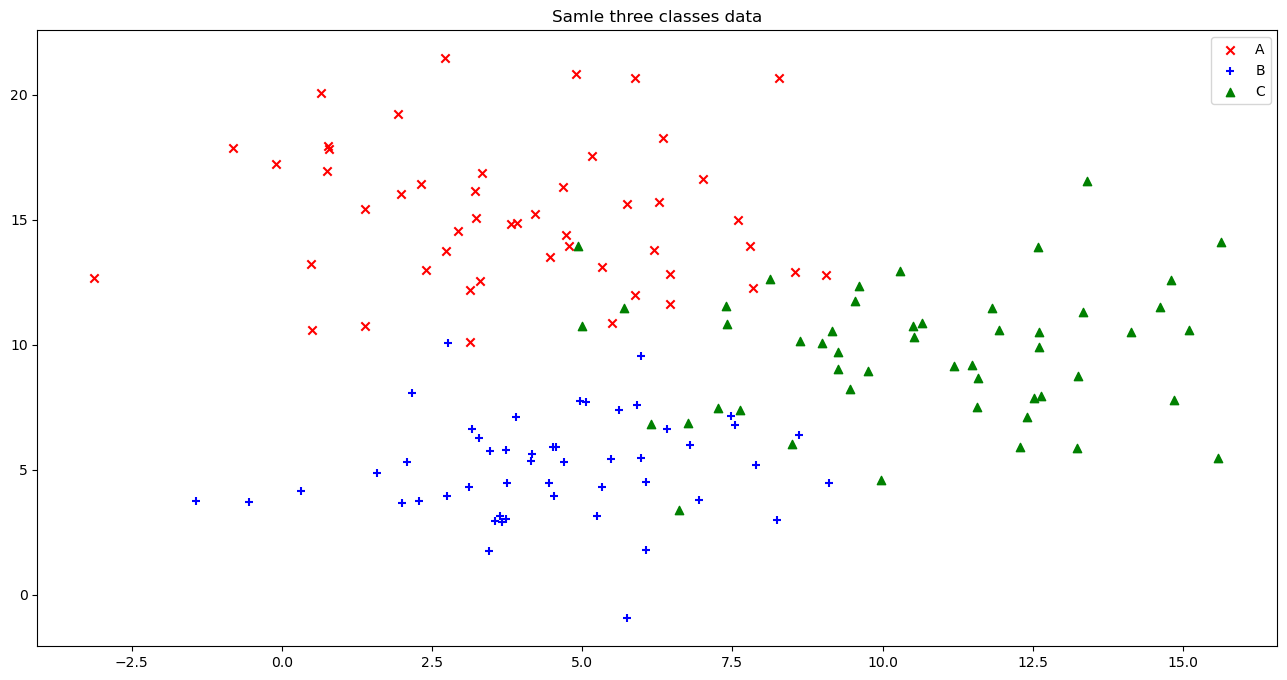

In [4]:
plt.figure(figsize=(16,8))
plt.scatter(a_[:, 0], a_[:, 1], color='red', marker='x', label='A')
plt.scatter(b_[:, 0], b_[:, 1], color='blue', marker='+', label='B')
plt.scatter(c_[:, 0], c_[:, 1], color='green', marker='^', label='C')

plt.legend(loc='best')
plt.title('Samle three classes data')

Let's put this data into a dataset and split it into training and test sets.

In [5]:
data = pd.DataFrame(np.concatenate([a_, b_, c_], axis=0), columns=['x1', 'x2', 't'])
ds = my.DataSet(data, y=True)
train, test = ds.train_test_split(test_portion=.33, shuffle=True)

Let's train this classifier and print its output on the training set side by side with the actual training labels.

In [6]:
nn = NearestNeighborClassifier(train)

results = pd.DataFrame(columns=["Actual", "Predicted"])

results["Actual"] = train.target.flatten()
results["Predicted"] = nn.predict(train.inputs)
results.head(10)

,Actual,Predicted
0,0.0,0.0
1,2.0,2.0
2,2.0,2.0
3,0.0,0.0
4,1.0,1.0
5,0.0,0.0
6,1.0,1.0
7,0.0,0.0
8,2.0,2.0
9,2.0,2.0


Here is the corresponding confusion matrix and accuracy.

In [7]:
cm = my.confusion_matrix(train.target, nn.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Train accuracy: ', accuracy)

[[37  0  0]
 [ 0 33  0]
 [ 0  0 31]]
Train accuracy:  1.0


This is a perfect accuracy which corresponds to a training error of $\boldsymbol{E}_{train} = 0$. This is not necessarily a good thing. **Why?**

Let's see how this trained model performs on the unseen test set. 

In [8]:
results = pd.DataFrame(columns=["Actual", "Predicted"])

results["Actual"] = test.target.flatten()
results["Predicted"] = nn.predict(test.inputs)
results.head(10)

,Actual,Predicted
0,1.0,1.0
1,2.0,2.0
2,0.0,0.0
3,0.0,0.0
4,1.0,1.0
5,0.0,0.0
6,0.0,0.0
7,2.0,2.0
8,1.0,1.0
9,2.0,2.0


Here is the corresponding confusion matrix and accuracy.

In [9]:
cm = my.confusion_matrix(test.target, nn.predict(test.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Test accuracy: ', accuracy)

[[12  0  1]
 [ 0 12  5]
 [ 5  0 14]]
Test accuracy:  0.7755102040816326


Here are the decision regions of this trained model with both the training examples and the test examples side by side. **Uncomment the `%%timeit` command to see how long it takes to produce these plots and get a feeling of how computationally expensive the NN classifier can be.** Keep in mind that `%%timeit` will run your code multiple times to get a more accurate measure of how long it took. So it may take a while to finish.

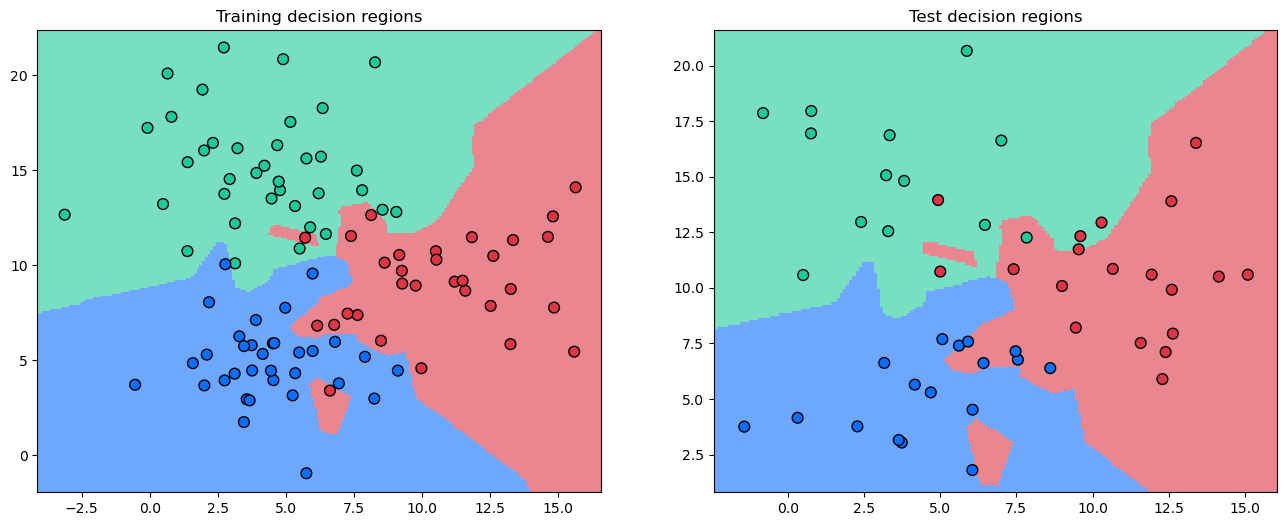

In [10]:
#%%timeit
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
my.plot_decision_regions(train.inputs, train.target, nn, title="Training decision regions", ax=ax)
ax = fig.add_subplot(1,2,2)
my.plot_decision_regions(test.inputs, test.target, nn, title="Test decision regions", ax=ax)

## A more efficient implementation
The way class `NearestNeighborClassifier` calculated the distances can be improved by taking advantage of NumPy vectorization. Here is a shorter and improved version. **Do you see the difference?**

In [11]:
class NearestNeighborClassifier:
    def __init__(self, dataset):
        self.ds = dataset
    
    def predict(self, unseen):
        if unseen.ndim == 1:
            distances = np.sqrt(np.sum((self.ds.inputs-unseen)**2, axis=1))

            return self.ds.target[distances.argmin()]
        else:
            return np.array([self.predict(ex) for ex in unseen])

Using the above example, to test this new class gives the following for the training set 

In [12]:
nn = NearestNeighborClassifier(train)

results = pd.DataFrame(columns=["Actual", "Predicted"])

results["Actual"] = train.target.flatten()
results["Predicted"] = nn.predict(train.inputs)
print(results.head(10))

cm = my.confusion_matrix(train.target, nn.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Train accuracy: ', accuracy)

   Actual  Predicted
0     0.0        0.0
1     2.0        2.0
2     2.0        2.0
3     0.0        0.0
4     1.0        1.0
5     0.0        0.0
6     1.0        1.0
7     0.0        0.0
8     2.0        2.0
9     2.0        2.0
[[37  0  0]
 [ 0 33  0]
 [ 0  0 31]]
Train accuracy:  1.0


and the following for the test set:

In [13]:
results = pd.DataFrame(columns=["Actual", "Predicted"])

results["Actual"] = test.target.flatten()
results["Predicted"] = nn.predict(test.inputs)
print(results.head(10))

cm = my.confusion_matrix(test.target, nn.predict(test.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Test accuracy: ', accuracy)

   Actual  Predicted
0     1.0        1.0
1     2.0        2.0
2     0.0        0.0
3     0.0        0.0
4     1.0        1.0
5     0.0        0.0
6     0.0        0.0
7     2.0        2.0
8     1.0        1.0
9     2.0        2.0
[[12  0  1]
 [ 0 12  5]
 [ 5  0 14]]
Test accuracy:  0.7755102040816326


This is no longer a perfect accuracy meaning that test error of $\boldsymbol{E}_{test} > 0$.

Here are again the decision regions of this trained model with both the training examples and the test examples side by side. **Uncomment the `%%timeit` command to see how long it takes to produce these plots using the improved NN classifier and compare that to the performance of the first implementation.**

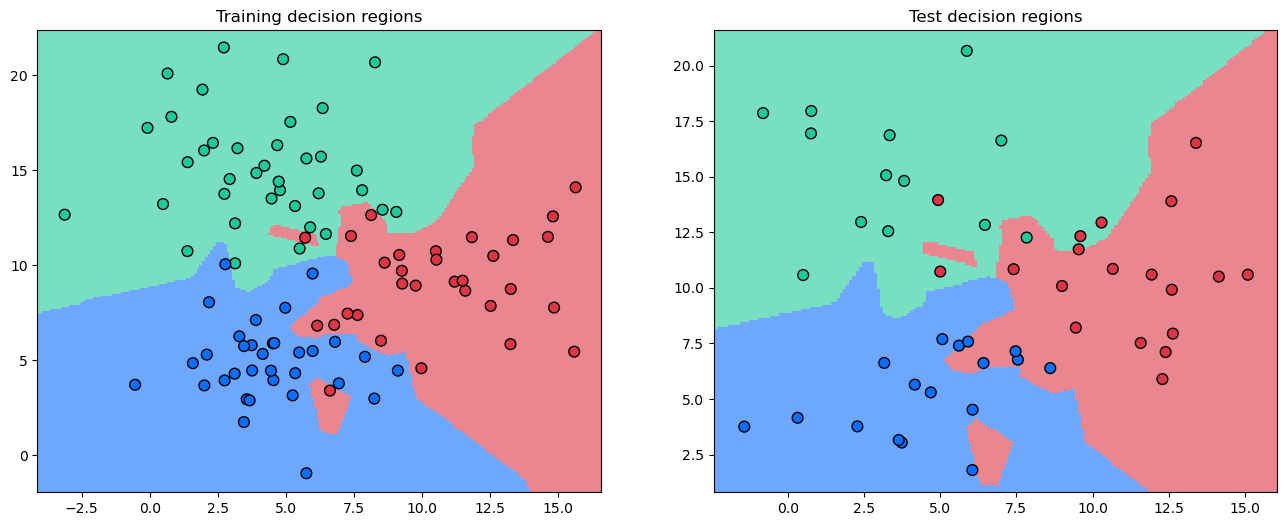

In [14]:
#%%timeit
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
my.plot_decision_regions(train.inputs, train.target, nn, title="Training decision regions", resolution=.1, ax=ax)
ax = fig.add_subplot(1,2,2)
my.plot_decision_regions(test.inputs, test.target, nn, title="Test decision regions", resolution=.1, ax=ax)

## EXERCISE
Write a function that takes a confusion matrix with more than two classes (such as the above `cm` matrix with 3 classes: `A`, `B`, and `C`) and a class index (such as 0, 1, or 2) and returns the sensitivity, specificity, precision, and $F_1$ metrics for the class of the given index given the confusion matrix. Test your function on the above confusion matrix `cm`.

**HINT**: Convert the confusion matrix into a $2 \times 2$ matrix representing the given class versus everything else.

In [15]:
# TODO